# Project 7 - SVM & Bayes

Κωνσταντίνα Μαρίνα Μπλέτσα, ΑΕΜ:243

# Εισαγωγή Βιβλιοθηκών

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Ερώτημα 1

Διαχωρισμός train–test (90%–10%)

In [16]:
df = pd.read_csv("train.csv")

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=0
)

Bar-plots για το πλήθος των target

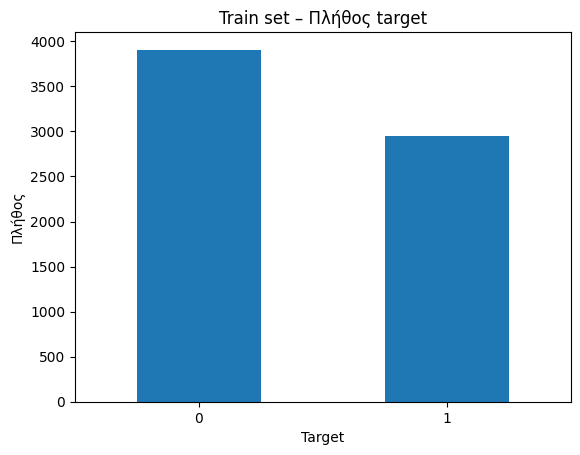

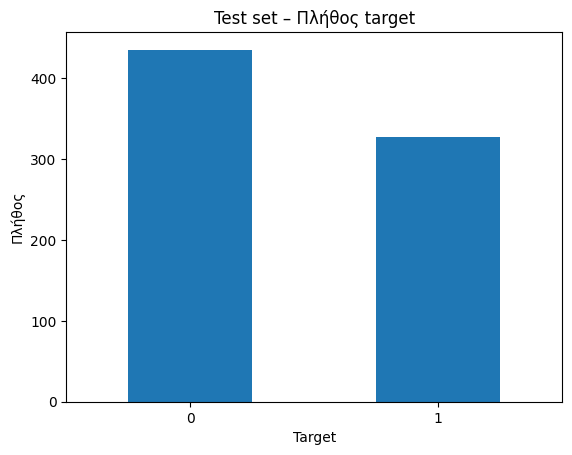

In [17]:
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

plt.figure()
train_counts.plot(kind="bar")
plt.title("Train set – Πλήθος target")
plt.xlabel("Target")
plt.ylabel("Πλήθος")
plt.xticks(rotation=0)
plt.show()

plt.figure()
test_counts.plot(kind="bar")
plt.title("Test set – Πλήθος target")
plt.xlabel("Target")
plt.ylabel("Πλήθος")
plt.xticks(rotation=0)
plt.show()

Στο Train set Target 0: 3907 ενώ Target 1: 2944

Στο Test set Target 0: 435 ενώ Target 1: 327

Συνεπώς το dataset είναι σχετικά ισορροπημένο, όχι πλήρως αλλά θεωρούμε πως τα μοντέλα μπορούν να δουλεψουν καλά.

# Ερώτημα 2

Αφαίρεση των χαρακτηριστικών id, location

In [18]:
X_train = X_train.drop(columns=["id", "location"])
X_test = X_test.drop(columns=["id", "location"])

Συμπλήρωση ελλιπών τιμών με το keyword "null" και Ένωση στηλών keyword και text στην στήλη inputs

In [19]:
X_train = X_train.fillna("null")
X_test = X_test.fillna("null")

X_train["inputs"] = X_train["keyword"] + " " + X_train["text"]
X_test["inputs"] = X_test["keyword"] + " " + X_test["text"]

X_train = X_train.drop(columns=["keyword", "text"])
X_test = X_test.drop(columns=["keyword", "text"])

# Ερώτημα 3

Ορισμός συνάρτησης preprocessing

In [20]:
def preprocess_text(text):
    text = str(text)

    text = text.encode("ascii", "ignore").decode()

    text = text.lower()

    text = re.sub(r"http\S+|www\S+", "", text)

    text = re.sub(r"@\w+|#\w+", "", text)

    text = re.sub(r"\d+", "", text)

    text = text.translate(str.maketrans("", "", string.punctuation))

    text = re.sub(r"\s+", " ", text).strip()

    return text


Εφαρμογή της Συνάρτησης στα train και test

In [21]:
X_train["inputs"] = X_train["inputs"].apply(preprocess_text)
X_test["inputs"] = X_test["inputs"].apply(preprocess_text)

In [22]:
X_train["inputs"].head()


,inputs
6669,threat meek mill responds to drakes ovo fest s...
3940,flood survived the plague floated the flood ju...
7217,weapons hendrixonfire blackcats big noob conqu...
2234,deluge vince mcmahon once again a billionaire ...
4233,hazardous is it possible to sneak into a hospi...


Αφαίρεση unicode / emoji δηλαδή αφαιρεί χαρακτήρες που δεν ειναι ASCII και emoji που δεν προσφέρουν πληροφορία

Το Lowercasing μετατρέπει όλο το κείμενο σε πεζά για ενοποίηση λέξεων και ομοιομορφία                            |
Αφαίρεση URLs, δηλαδή αφαιρεί συνδέσμους που δεν συμβάλλουν στη σημασία του tweet

Αφαίρεση mentions / hashtags, δηλαδη αφαιρεί usernames και hashtags που εισάγουν θόρυβο χωρις καποια χρήσιμη πληροφορια

Αφαίρεση αριθμών που συνήθως δεν έχουν γλωσσική σημασία

Αφαίρεση σημείων στίξης, δηλαδη καθαρίζει το κείμενο από σύμβολα  

Αφαίρεση extra κενών, για να εχει ομοιόμορφη μορφή το κειμενο

Οι παραπάνω τεχνικές προεπεξεργασίας εγιναν για να μειωθει ο θορύβος και να εχει ομοιομορφία το κειμενο, χωρις ομως να χαθεί η χρήσιμη πληροφορία των tweets.

# Ερώτημα 4

Μετατροπή των inputs και των targets σε numpy arrays

In [24]:
X_train_inputs = X_train["inputs"].to_numpy()
X_test_inputs = X_test["inputs"].to_numpy()

y_train_targets = y_train.to_numpy()
y_test_targets = y_test.to_numpy()

In [26]:
print(type(X_train_inputs), X_train_inputs.shape)
print(type(y_train_targets), y_train_targets.shape)
print(type(X_test_inputs), X_test_inputs.shape)
print(type(y_test_targets), y_test_targets.shape)


<class 'numpy.ndarray'> (6851,)
<class 'numpy.ndarray'> (6851,)
<class 'numpy.ndarray'> (762,)
<class 'numpy.ndarray'> (762,)


# Ερώτημα 5

Δημιουργία του TfidfVectorizer

In [28]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_df=0.95,
    min_df=2
)

fit_transform στο train set και transform στο test set

In [29]:
X_train_tfidf = tfidf.fit_transform(X_train_inputs)
X_test_tfidf = tfidf.transform(X_test_inputs)

In [30]:
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape:", X_test_tfidf.shape)

Train TF-IDF shape: (6851, 5236)
Test TF-IDF shape: (762, 5236)


# Ερώτημα 6

Εκπαίδευση του Ταξινομητή Linear SVM

In [32]:
svm_clf = LinearSVC(random_state=0)
svm_clf.fit(X_train_tfidf, y_train_targets)


LinearSVC(random_state=0)

In [33]:
y_train_pred = svm_clf.predict(X_train_tfidf)
y_test_pred = svm_clf.predict(X_test_tfidf)

Υπολογισμός και Εκτύπωση των Accuracy, F1, Precision, Recall

In [35]:
train_accuracy = accuracy_score(y_train_targets, y_train_pred)
train_f1 = f1_score(y_train_targets, y_train_pred)
train_precision = precision_score(y_train_targets, y_train_pred)
train_recall = recall_score(y_train_targets, y_train_pred)

test_accuracy = accuracy_score(y_test_targets, y_test_pred)
test_f1 = f1_score(y_test_targets, y_test_pred)
test_precision = precision_score(y_test_targets, y_test_pred)
test_recall = recall_score(y_test_targets, y_test_pred)


In [36]:
print("TRAIN")
print(f"Accuracy : {train_accuracy:.4f}")
print(f"F1-score : {train_f1:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall   : {train_recall:.4f}")

print("\nTEST")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"F1-score : {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")

TRAIN
Accuracy : 0.9330
F1-score : 0.9193
Precision: 0.9530
Recall   : 0.8879

TEST
Accuracy : 0.8136
F1-score : 0.7746
Precision: 0.8053
Recall   : 0.7462


Το F1-score θεωρείται η πιο σημαντική μετρική, καθώς συνδυάζει precision και recall. Στο συγκεκριμένο πρόβλημα, όπου το σύνολο δεδομένων δεν είναι πλήρως ισορροπημένο, η ακρίβεια (accuracy) μπορεί να είναι παραπλανητική. Το F1-score δειχνει πιο αξιόπιστα την απόδοση του μοντέλου, λαμβάνοντας υπόψη τόσο τα ψευδώς θετικά όσο και τα ψευδώς αρνητικά σφάλματα.

# Ερώτημα 7

Μετασχηματισμός PCA στα δεδομένα

In [38]:
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

pca = PCA(n_components=0.95, random_state=0)

X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)


In [39]:
print("Αριθμός συνιστωσών PCA:", pca.n_components_)

Αριθμός συνιστωσών PCA: 2560


Εκπαίδευση LinearSVC στο PCA space

In [41]:
linear_svc_pca = LinearSVC(random_state=0)
linear_svc_pca.fit(X_train_pca, y_train_targets)

y_test_pred_linear = linear_svc_pca.predict(X_test_pca)

Εκπαίδευση SVC με RBF kernel στο PCA space

In [43]:
rbf_svc = SVC(kernel="rbf", random_state=0)
rbf_svc.fit(X_train_pca, y_train_targets)

y_test_pred_rbf = rbf_svc.predict(X_test_pca)

Υπολογισμός μετρικών (TEST set)

In [44]:
def print_metrics(y_true, y_pred, title):
    print(title)
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print()


In [45]:
print_metrics(y_test_targets, y_test_pred_linear, "LinearSVC + PCA")
print_metrics(y_test_targets, y_test_pred_rbf, "SVC (RBF) + PCA")

LinearSVC + PCA
Accuracy : 0.8083989501312336
F1-score : 0.7697160883280757
Precision: 0.7947882736156352
Recall   : 0.746177370030581

SVC (RBF) + PCA
Accuracy : 0.821522309711286
F1-score : 0.7785016286644951
Precision: 0.8327526132404182
Recall   : 0.7308868501529052



Ο ταξινομητής SVC με RBF kernel εχει λίγο υψηλότερη Accuracy (0.822 έναντι 0.808) και F1-score (0.779 έναντι 0.770). Επιπλέον, εμφανίζει σημαντικά υψηλότερη Precision (0.833), κάτι που σημαίνει ότι παράγει λιγότερα ψευδώς θετικά αποτελέσματα.

Αντίθετα, ο LinearSVC παρουσιάζει υψηλότερη Recall (0.746 έναντι 0.731), το οποιο δείχνει ότι είναι πιο καλος στον εντοπισμό των πραγματικά θετικών περιπτώσεων. Αυτό είναι ιδιαίτερα σημαντικό στο συγκεκριμένο πρόβλημα, καθώς η μη ανίχνευση ενός πραγματικού tweet σχετικού με καταστροφή μπορεί να έχει μεγαλύτερο κόστος από έναν ψευδή συναγερμό.

Συνεπώς, παρότι ο SVC με RBF kernel εμφανίζει οριακά καλύτερη συνολική απόδοση, ο LinearSVC παραμένει ιδιαίτερα ανταγωνιστικός και πιο κατάλληλος σε σενάρια όπου το Recall είναι κρίσιμο.

# Ερώτημα 8

Στον SVC με RBF kernel, η παράμετρος gamma ελέγχει το πόσο τοπική είναι η επιρροή κάθε δείγματος. Η παράμετρος gamma='scale' είναι η προτεινόμενη default επιλογή και εξαρτάται από τον αριθμό των χαρακτηριστικών και την διακύμανση των δεδομένων.

Αν η παραμετρος gamma='auto'τότε δεν λαμβάνει υπόψη τη διακύμανση και ειναι πιο απλή αλλά λιγότερο προσαρμοστική επιλογή.

Εκπαίδευση SVC με gamma='auto'

In [46]:
svc_auto = SVC(kernel="rbf", gamma="auto", random_state=0)
svc_auto.fit(X_train_pca, y_train_targets)

y_test_pred_auto = svc_auto.predict(X_test_pca)

Υπολογισμός μετρικών

In [47]:
auto_accuracy = accuracy_score(y_test_targets, y_test_pred_auto)
auto_f1 = f1_score(y_test_targets, y_test_pred_auto)
auto_precision = precision_score(y_test_targets, y_test_pred_auto)
auto_recall = recall_score(y_test_targets, y_test_pred_auto)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Δημιουργία bar-plot για Σύγκριση των μετρικών  accuracy, F1, precision, recall των τεσσάρων μοντέλων που εκπαιδεύτηκαν

In [48]:
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred)
    }

results = {}

# 1) LinearSVC με TF-IDF
linear_no_pca = LinearSVC(random_state=0)
linear_no_pca.fit(X_train_tfidf, y_train_targets)
pred = linear_no_pca.predict(X_test_tfidf)
results["LinearSVC"] = get_metrics(y_test_targets, pred)

# 2) LinearSVC + PCA
linear_pca = LinearSVC(random_state=0)
linear_pca.fit(X_train_pca, y_train_targets)
pred = linear_pca.predict(X_test_pca)
results["LinearSVC + PCA"] = get_metrics(y_test_targets, pred)

# 3) SVC RBF + PCA με gamma='scale' (default)
rbf_scale = SVC(kernel="rbf", gamma="scale", random_state=0)
rbf_scale.fit(X_train_pca, y_train_targets)
pred = rbf_scale.predict(X_test_pca)
results["SVC RBF (scale) + PCA"] = get_metrics(y_test_targets, pred)

# 4) SVC RBF + PCA με gamma='auto'
rbf_auto = SVC(kernel="rbf", gamma="auto", random_state=0)
rbf_auto.fit(X_train_pca, y_train_targets)
pred = rbf_auto.predict(X_test_pca)
results["SVC RBF (auto) + PCA"] = get_metrics(y_test_targets, pred)

metrics_df = pd.DataFrame(results).T
print(metrics_df)

                       Accuracy        F1  Precision    Recall
LinearSVC              0.813648  0.774603   0.805281  0.746177
LinearSVC + PCA        0.808399  0.769716   0.794788  0.746177
SVC RBF (scale) + PCA  0.821522  0.778502   0.832753  0.730887
SVC RBF (auto) + PCA   0.570866  0.000000   0.000000  0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Δημιουργία BAR PLOT

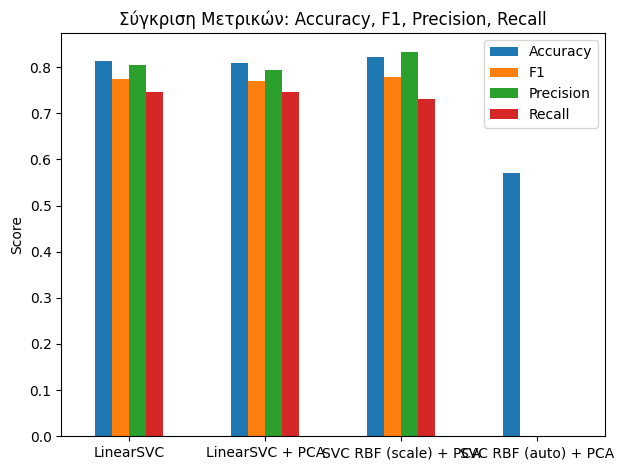

In [49]:
metrics_df.plot(kind="bar")
plt.title("Σύγκριση Μετρικών: Accuracy, F1, Precision, Recall")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Ερώτημα 9

Εκπαίδευση Μοντέλου Gaussian Naive Bayes

In [51]:
X_train_dense_nb = X_train_tfidf.toarray()
X_test_dense_nb = X_test_tfidf.toarray()

gnb = GaussianNB()
gnb.fit(X_train_dense_nb, y_train_targets)

GaussianNB()

In [52]:
y_train_pred_gnb = gnb.predict(X_train_dense_nb)
y_test_pred_gnb = gnb.predict(X_test_dense_nb)

Υπολογισμός Μετρικών & Εμφάνιση Αποτελεσμάτων

In [53]:
train_accuracy_gnb = accuracy_score(y_train_targets, y_train_pred_gnb)
train_f1_gnb = f1_score(y_train_targets, y_train_pred_gnb)
train_precision_gnb = precision_score(y_train_targets, y_train_pred_gnb)
train_recall_gnb = recall_score(y_train_targets, y_train_pred_gnb)

test_accuracy_gnb = accuracy_score(y_test_targets, y_test_pred_gnb)
test_f1_gnb = f1_score(y_test_targets, y_test_pred_gnb)
test_precision_gnb = precision_score(y_test_targets, y_test_pred_gnb)
test_recall_gnb = recall_score(y_test_targets, y_test_pred_gnb)


In [54]:
print("TRAIN – Gaussian Naive Bayes")
print(f"Accuracy : {train_accuracy_gnb:.4f}")
print(f"F1-score : {train_f1_gnb:.4f}")
print(f"Precision: {train_precision_gnb:.4f}")
print(f"Recall   : {train_recall_gnb:.4f}")

print("\nTEST – Gaussian Naive Bayes")
print(f"Accuracy : {test_accuracy_gnb:.4f}")
print(f"F1-score : {test_f1_gnb:.4f}")
print(f"Precision: {test_precision_gnb:.4f}")
print(f"Recall   : {test_recall_gnb:.4f}")

TRAIN – Gaussian Naive Bayes
Accuracy : 0.7624
F1-score : 0.7824
Precision: 0.6451
Recall   : 0.9939

TEST – Gaussian Naive Bayes
Accuracy : 0.6181
F1-score : 0.6612
Precision: 0.5338
Recall   : 0.8685
